# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

In this project I used the following techniques to detect the lane lines on the road:

    (x) Color space conversion
    (x) Gaussian Blur
    (x) Canny Edge Detection 
    (X) Region Selection 
    (X) Hough Transform
    (X) Linear Regression
    
    
Finally applied these techniques in processing the video to find the lanes on the road.

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Load Test Images

In [3]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

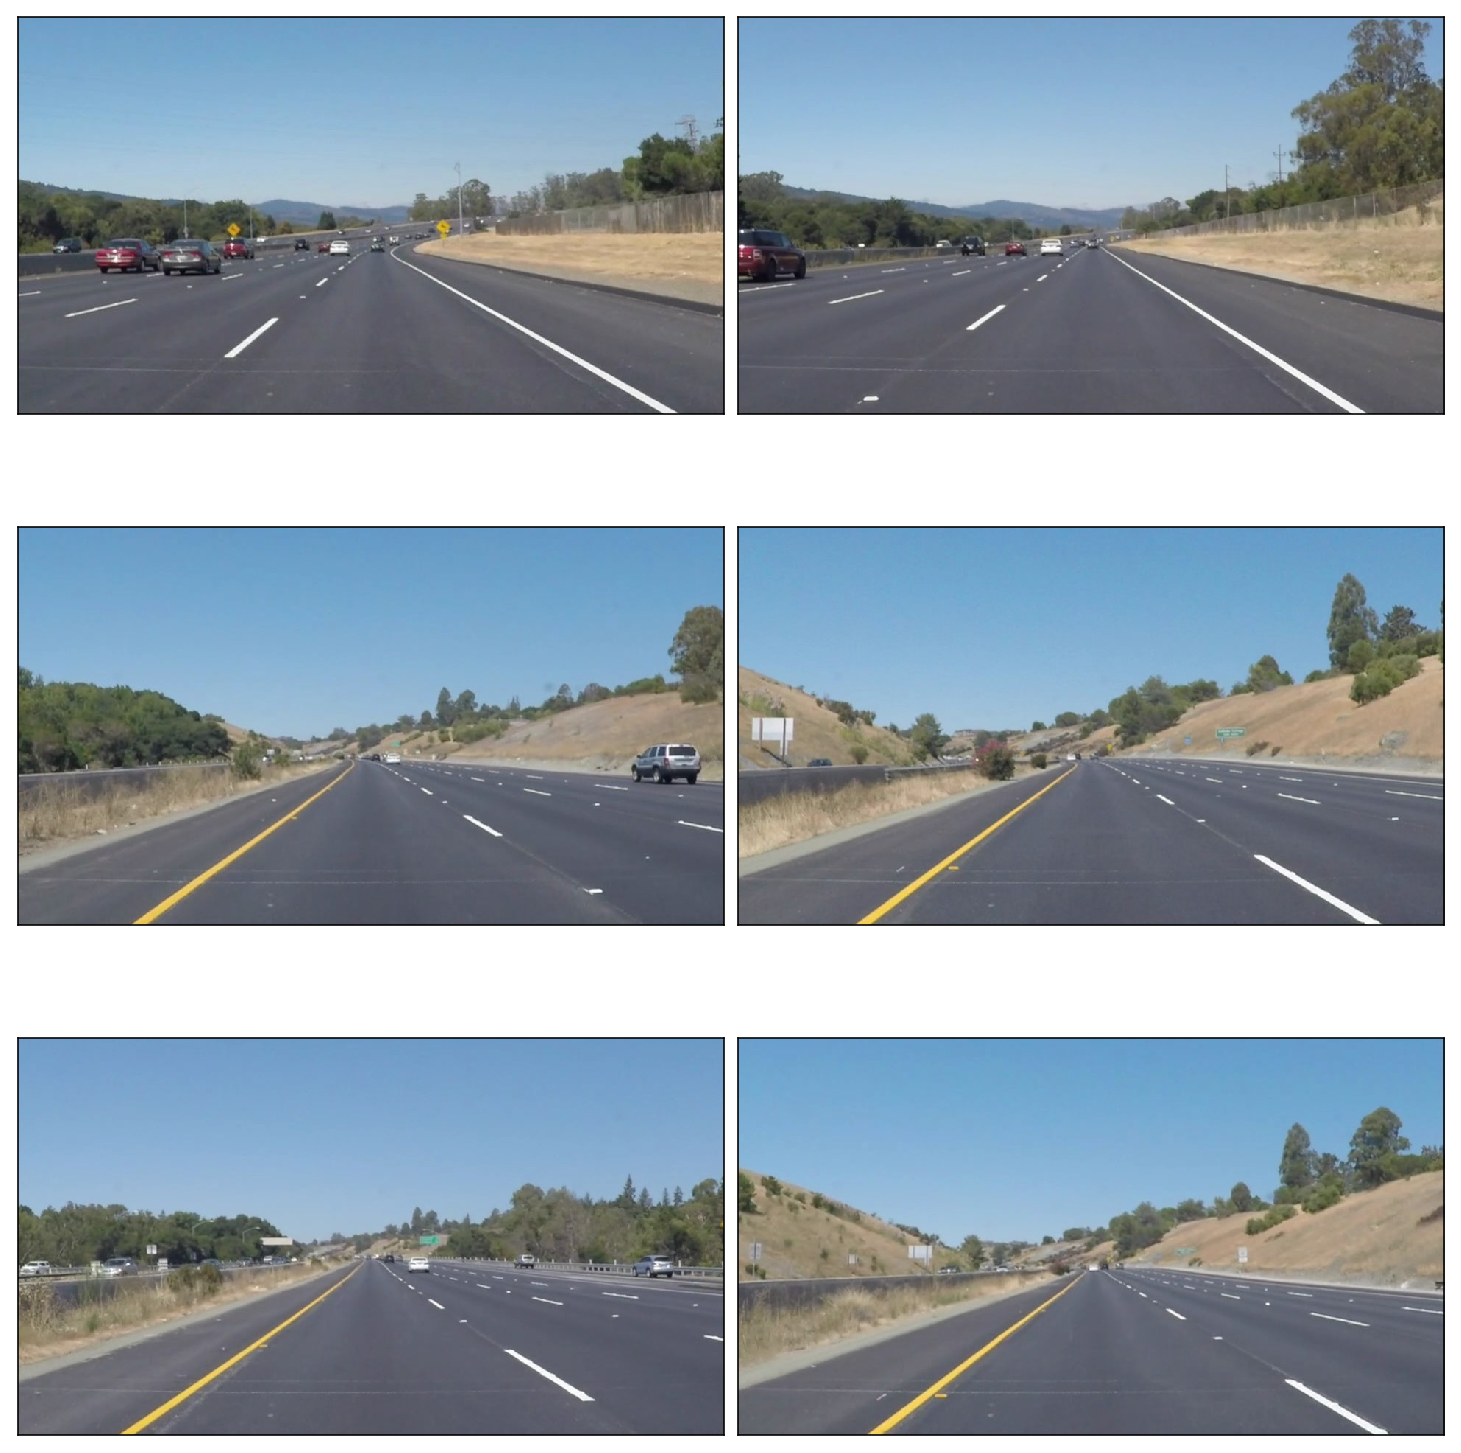

In [4]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

show_images(test_images)


## Converting Images to 'HLS Colorspace'

The first step in finding the lane lines is converting the image into HLS Color space. 

For the white color,

    I chose high Light value.
    I did not filter Hue, Saturation values.
For the yellow color,
    I chose Hue around 30 to choose yellow color.
    I chose relatively high Saturation to exclude yellow hills
    
    
The combined mask filters the yellow and white lines very clearly.


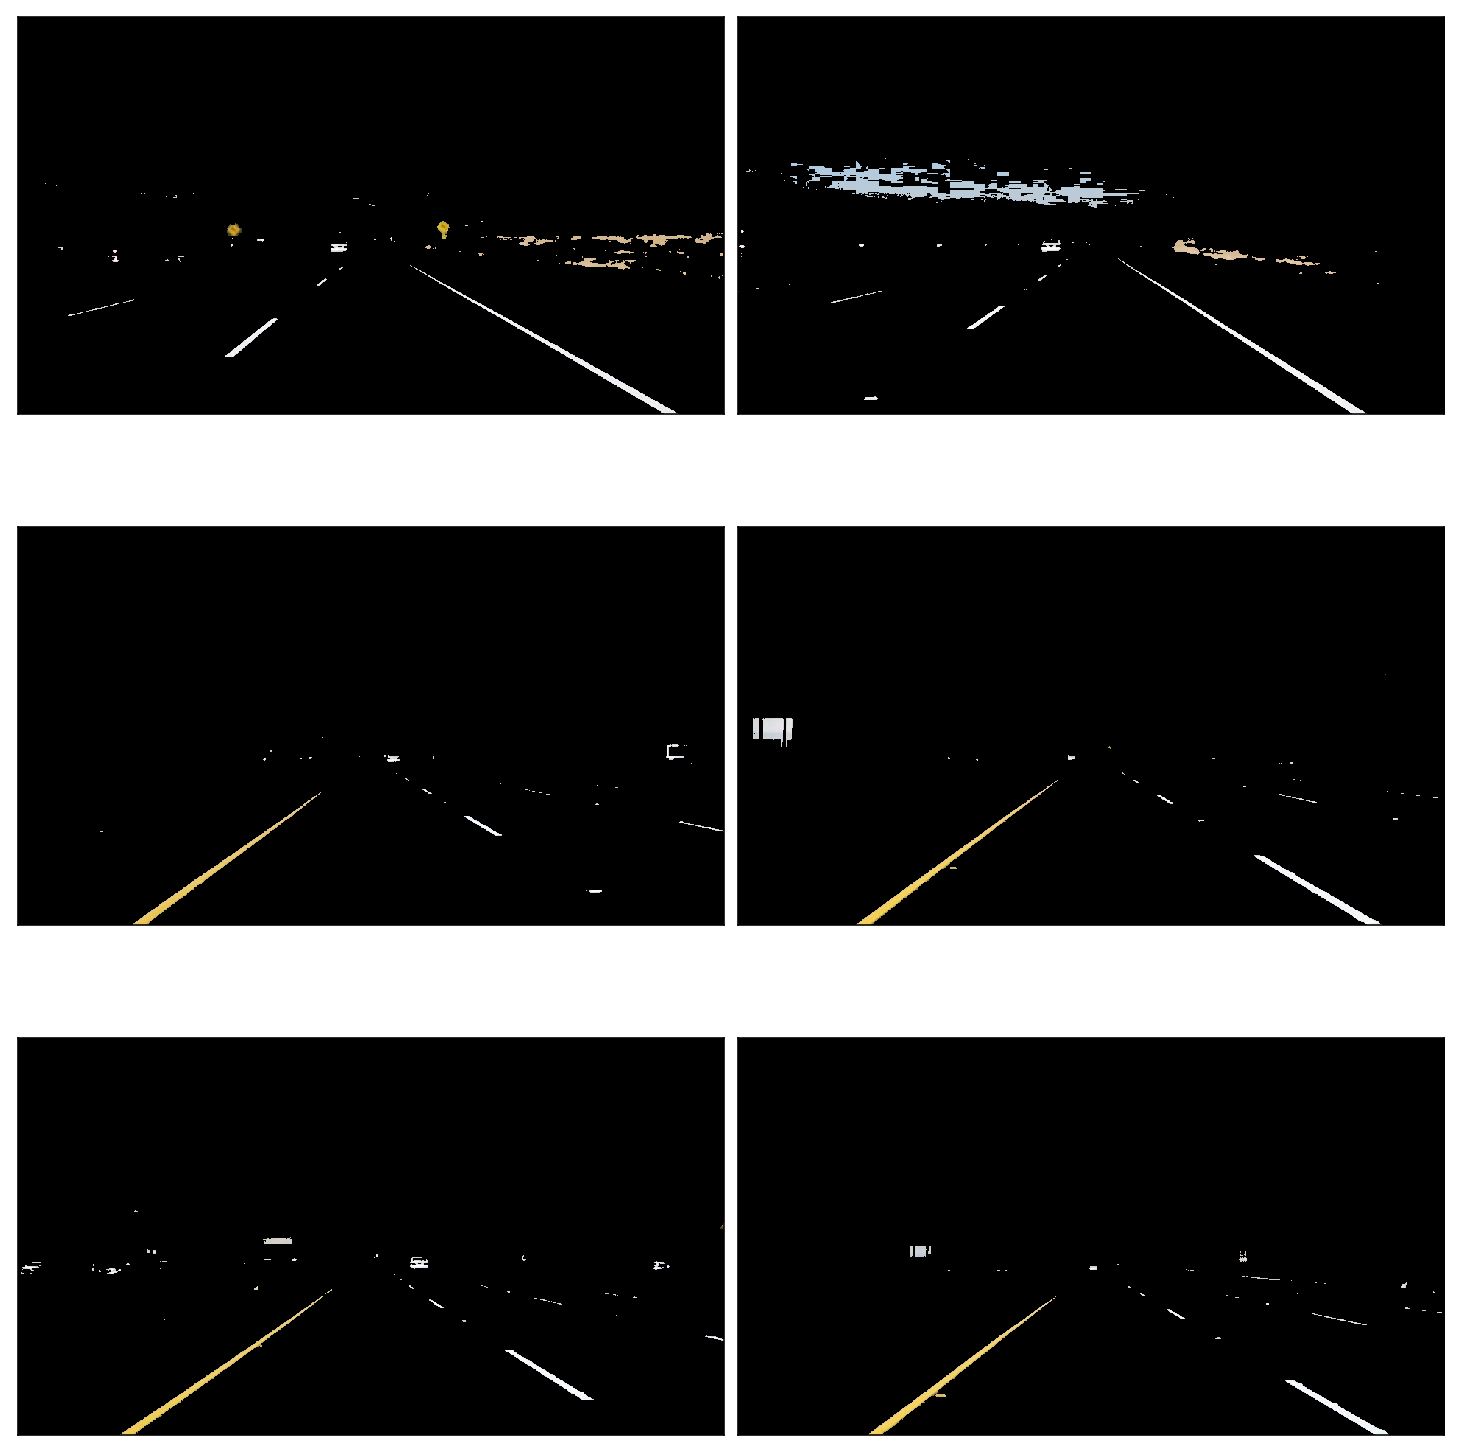

In [16]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)


white_yellow_images = list(map(select_white_yellow, test_images))

show_images(white_yellow_images)

## Applying Canny Edge 

The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986.

Our goal is to find the lines in the image specially the lane lines.

We use the following steps to find the edges in the image:

    (x) Convert to Grayscale
    (x) Apply Guassian Blur
    (x) Apply Canny Edge Detection


### Appling Gray Scaling

We use the 'cv2.cvtColor()' function in OpenCV to convert the image into gray scale. This step is important because the canny edge detection calculates the gradient difference between the pixel intensities of the image and the cv2.canny() accepts a grayscale image as argument.

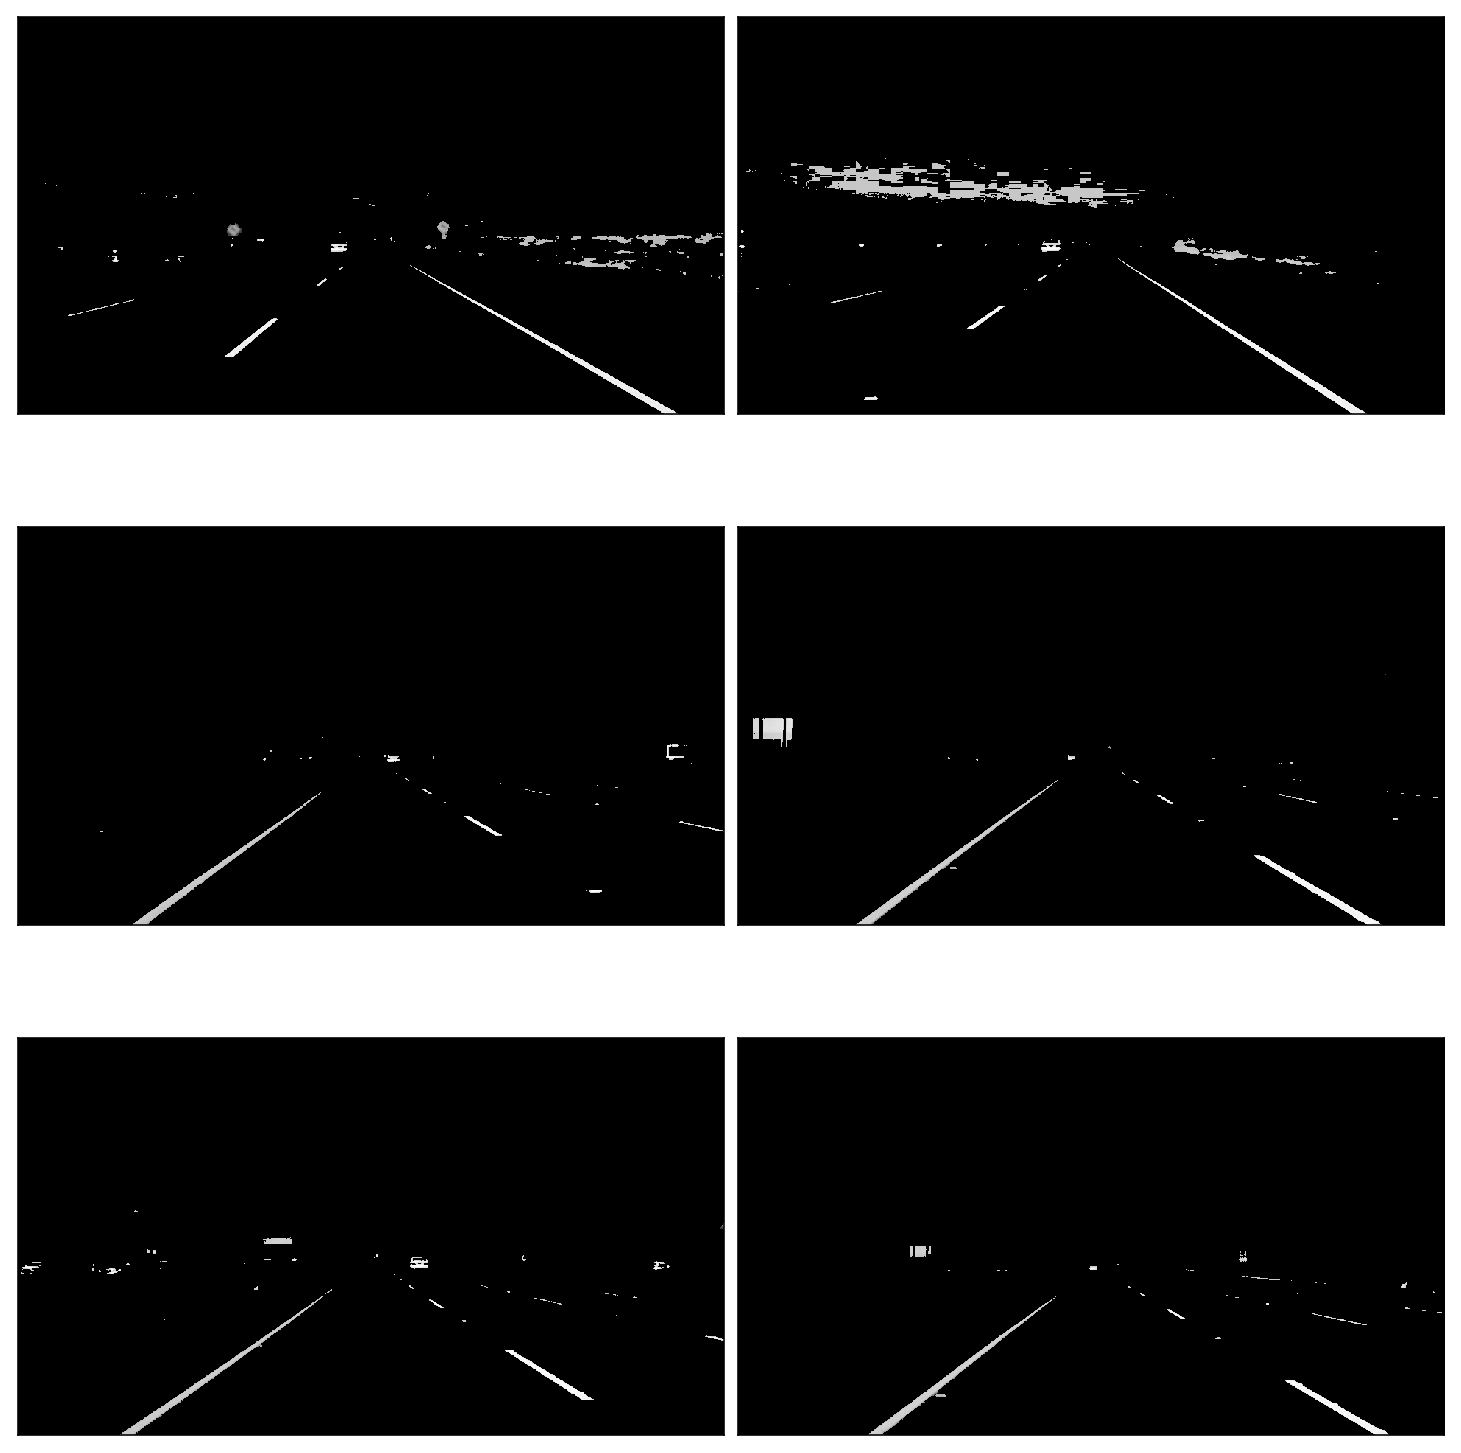

In [17]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

show_images(gray_images)

### Applying Gaussian Blur to the Images

This Step is mainly to reduce noise in the image and smoothen the irregularities in the image.
Since edge detection is susceptible to noise in the image, first step is to remove the noise in the image with a Gaussian filter. 
It is done with the function, cv2.GaussianBlur(). We should specify the width and height of kernel which should be positive and odd. The larger the kernel the more blur is the image.
Gaussian blurring is highly effective in removing gaussian noise from the image.

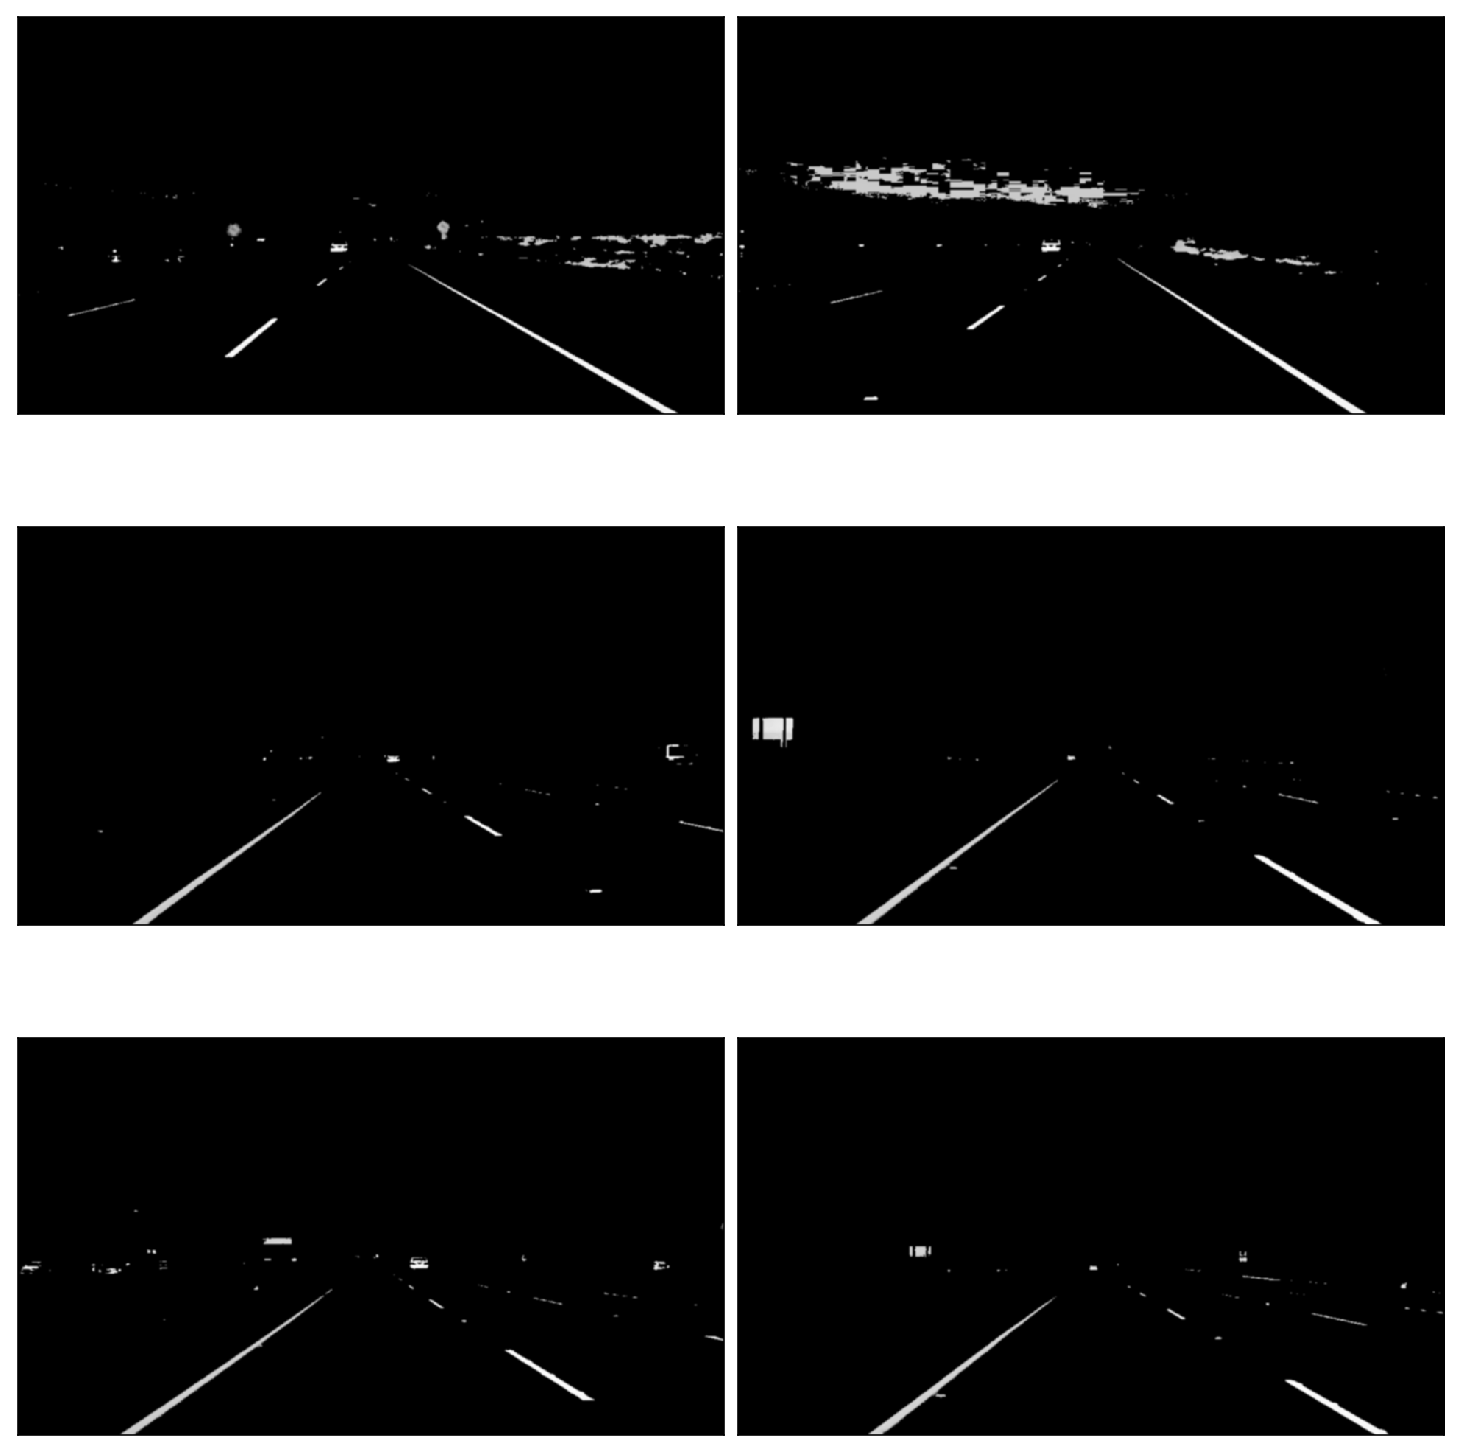

In [18]:
def apply_blur(gray):
    kernel = 5
    return cv2.GaussianBlur(gray,(kernel,kernel),0)

blur_images = list(map(apply_blur, gray_images))

show_images(blur_images)

### Applying Canny Edge  Detection 

The final step. Canny does use two thresholds (upper and lower):

    If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
    If a pixel gradient value is below the lower threshold, then it is rejected.
    If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is         above the upper threshold.
    
Canny recommended a upper:lower ratio between 2:1 and 3:1.

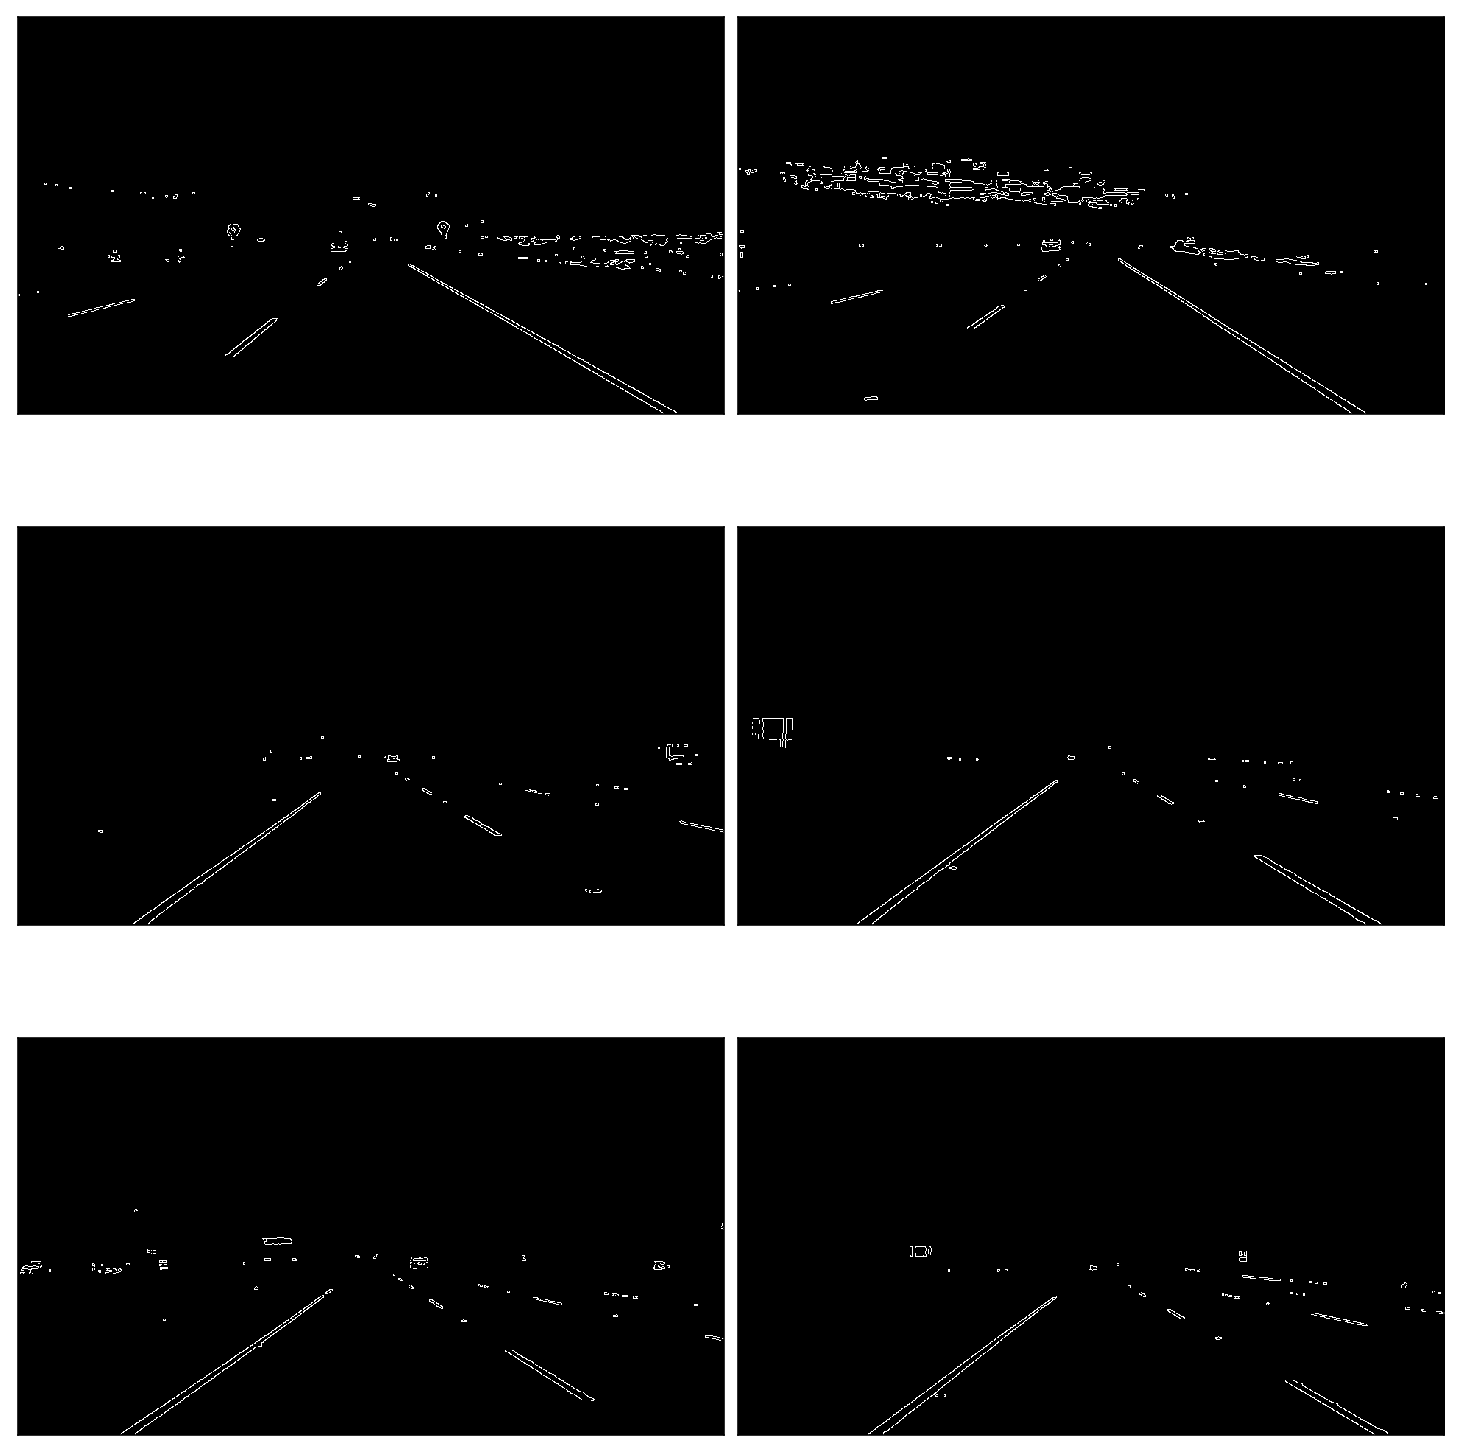

In [19]:
def apply_canny(gray_blur):
    low_threshold = 40
    high_threshold = 100
    edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
    return edges
blur_image = blur_images
canny_images = list(map(apply_canny, blur_image))

show_images(canny_images)

## Defining the Region of Interest (RoI)

We define our region of interest now. Given the position and orientation of the camera, we know that the lanes will be located in the lower half of the image, usually in a trapezoid covering the bottom corners and the center. We don’t want our region to be too narrow and have the lines out of our region of interest.

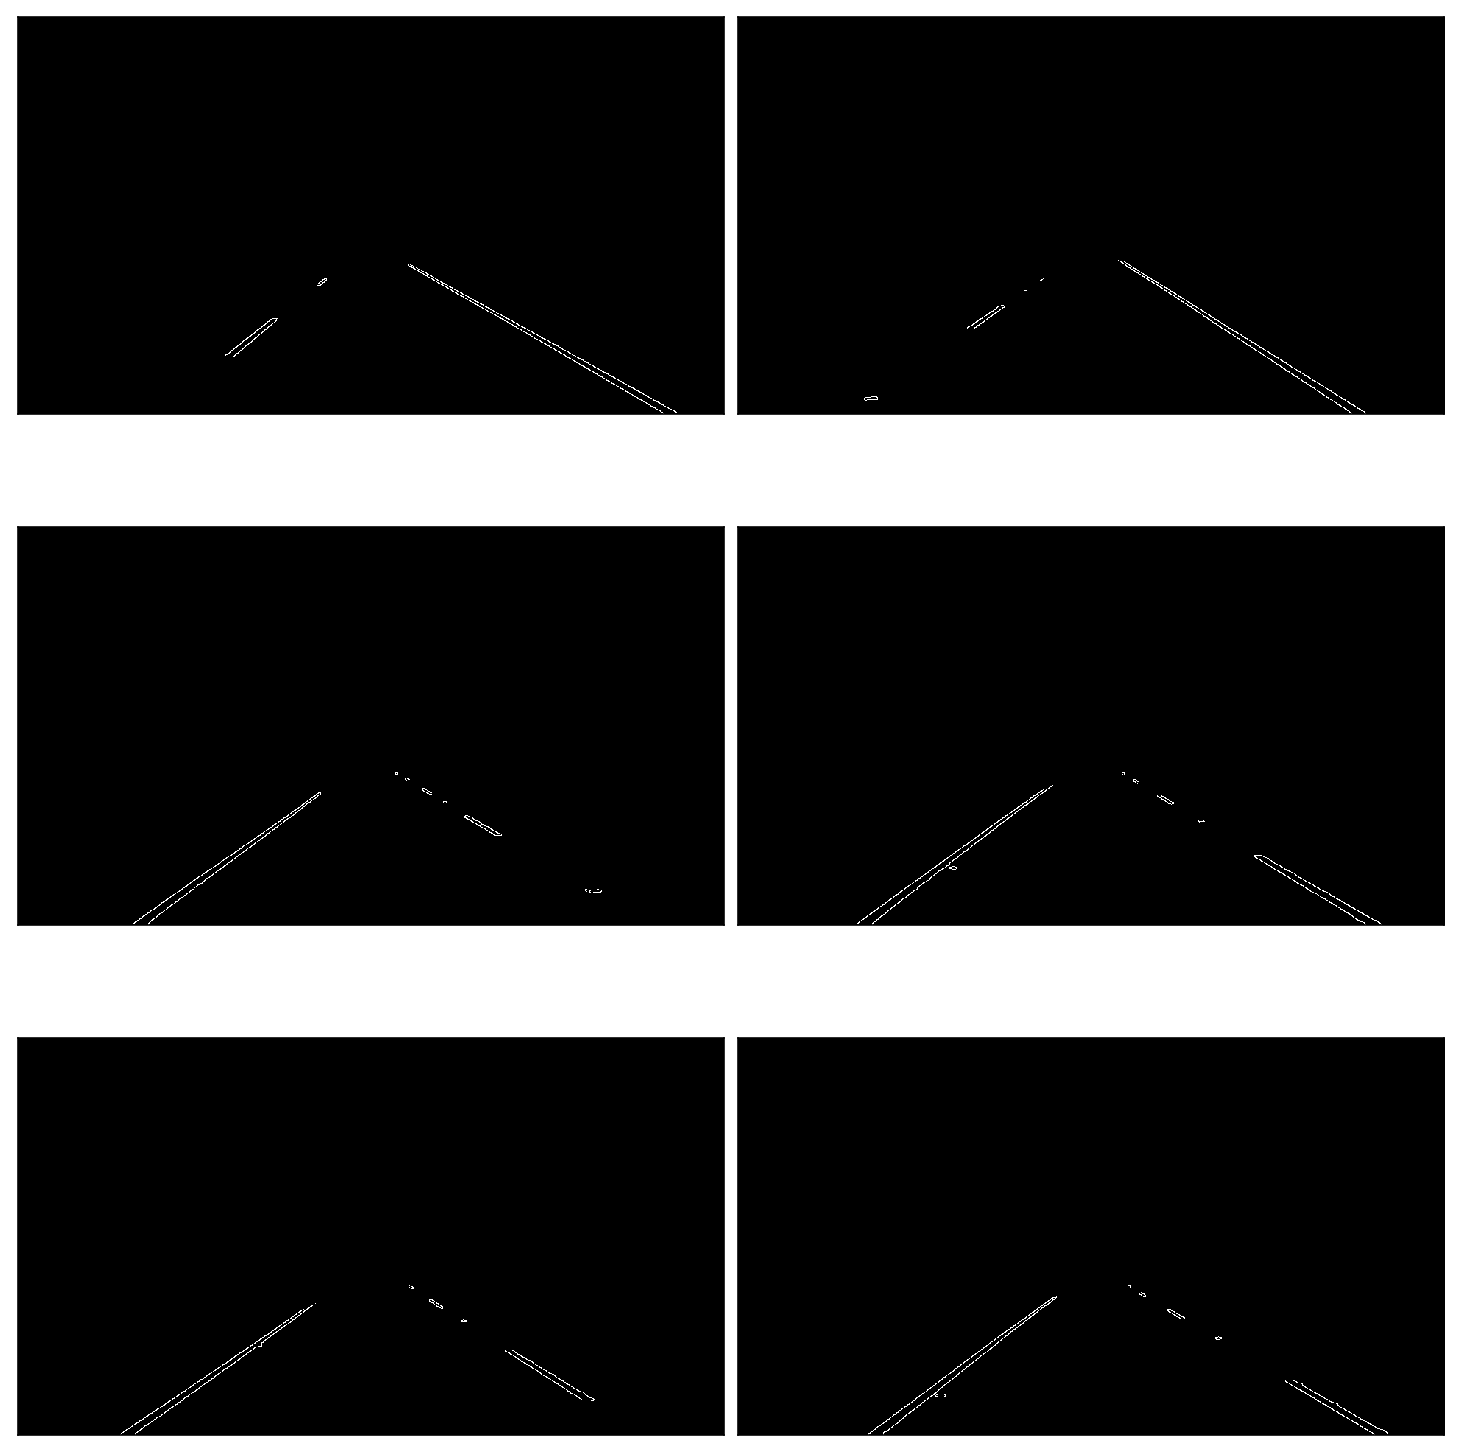

In [31]:
def roi(edges):
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = edges.shape
    vertices = np.array([[(40,imshape[0]),(imshape[1]*0.50, imshape[0]*0.60), (imshape[1]*0.55, imshape[0]*0.62), (imshape[1]*0.95,imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    return masked_edges

roi_images = list(map(roi, canny_images))

show_images(roi_images)

## Applying Hough Transform

Hough Transform is a popular technique to detect any shape, if you can represent that shape in mathematical form. It can detect the shape even if it is broken or distorted a little bit. We will see how it works for a line.

A line can be represented as y = mx+c or in parametric form, as \rho = x \cos \theta + y \sin \theta where \rho is the perpendicular distance from origin to the line, and \theta is the angle formed by this perpendicular line and horizontal axis measured in counter-clockwise

We use the OpenCV function, cv2.HoughLines(). It simply returns an array of (\rho, \theta) values. \rho is measured in pixels and \theta is measured in radians. First parameter, Input image should be a binary image, so apply threshold or use canny edge detection before finding applying hough transform. Second and third parameters are \rho and \theta accuracies respectively. Fourth argument is the threshold, which means minimum vote it should get for it to be considered as a line.

The following parameters need to be tweeked carefully to obtain the lines from the edges which we detected using the Canny edge detector:

    rho                 # distance resolution in pixels of the Hough grid
    theta               # angular resolution in radians of the Hough grid
    threshold           # minimum number of votes (intersections in Hough grid cell)
    min_line_length     # minimum number of pixels making up a line
    max_line_gap        # maximum gap in pixels between connectable line segments
    


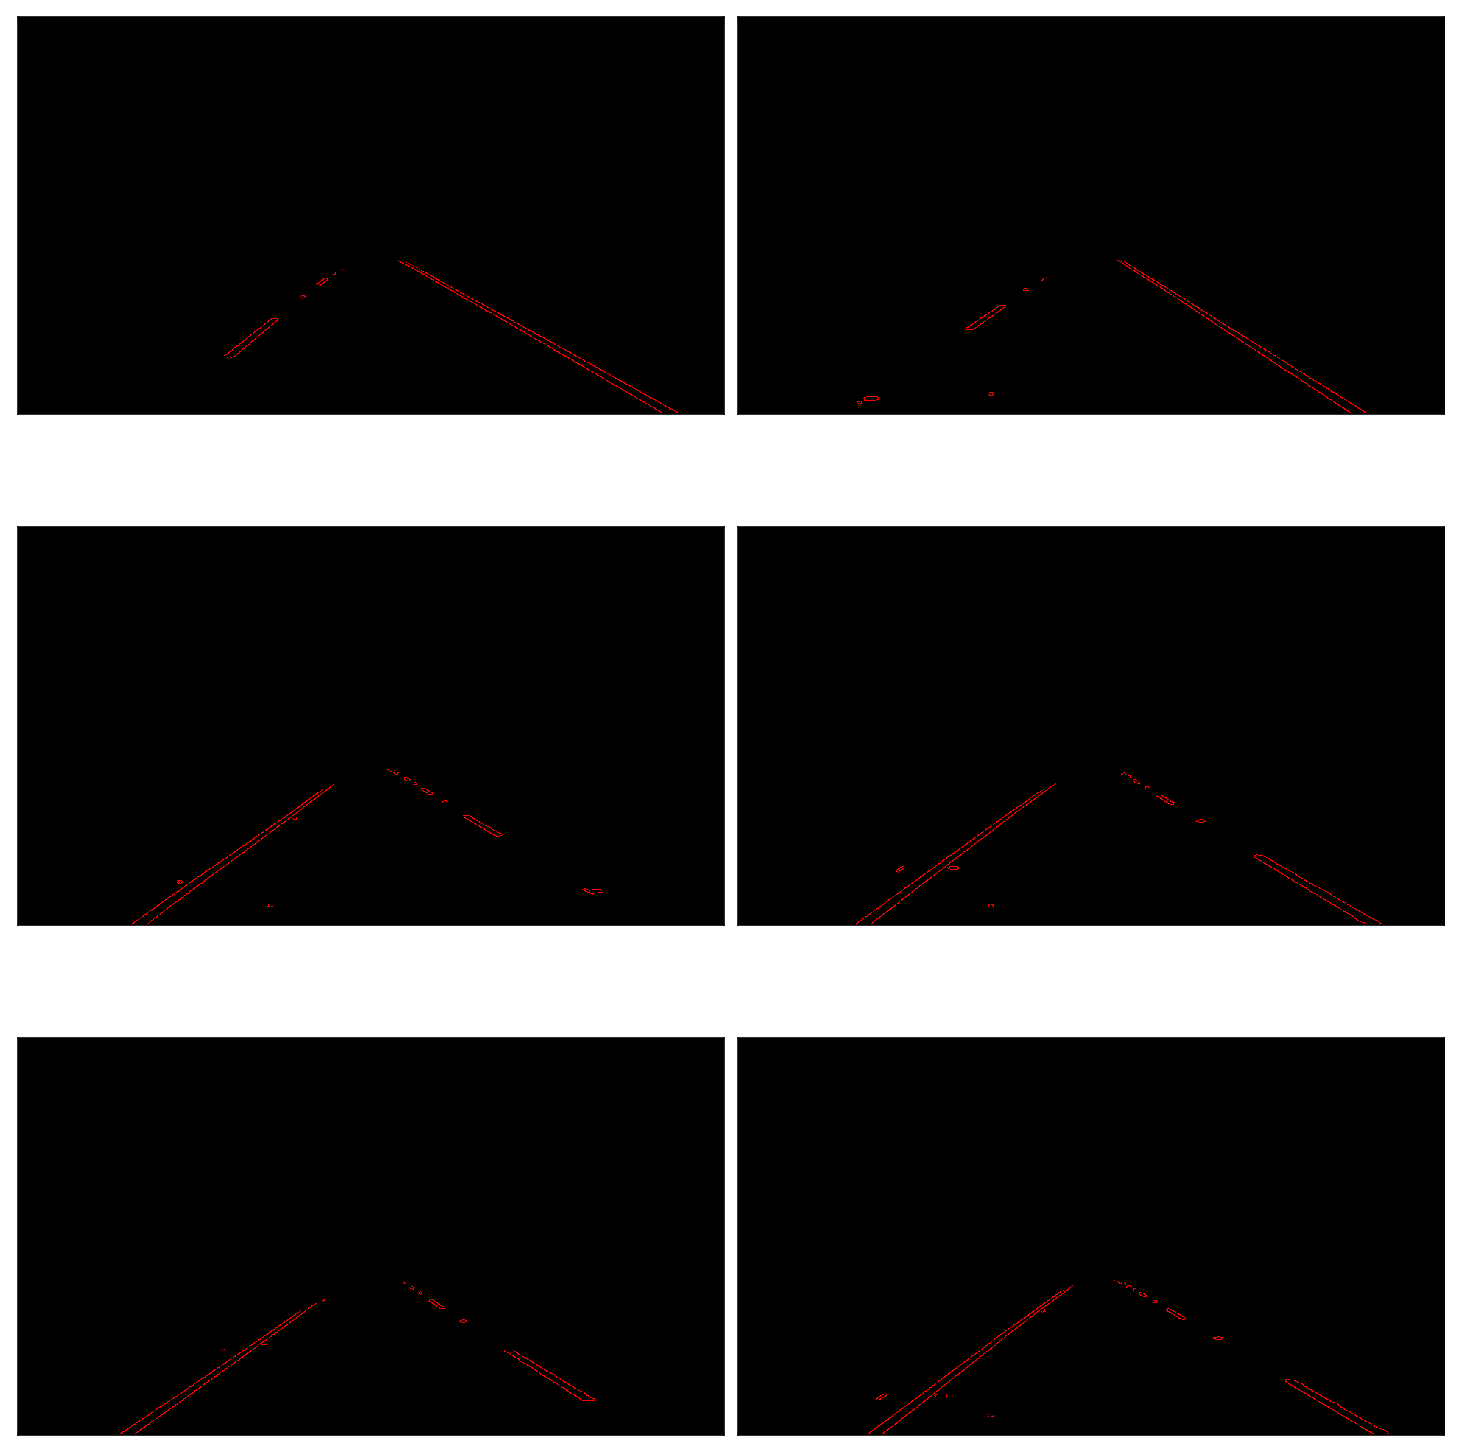

In [50]:
def apply_hough(image):
    gray = convert_gray_scale(image)
    blur = apply_blur(gray)
    edges = apply_canny(blur)
    masked_edges = roi(edges)
    
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1                                          # distance resolution in pixels of the Hough grid
    theta = np.pi/180                                # angular resolution in radians of the Hough grid
    threshold = 16                                   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20                             # minimum number of pixels making up a line
    max_line_gap = 20                                # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0                    # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    return lines
def show_hough(image):
    gray = convert_gray_scale(image)
    blur = apply_blur(gray)
    edges = apply_canny(blur)
    masked_edges = roi(edges)
    line_image = np.copy(image)*0                    # creating a blank to draw lines on
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2                                          # distance resolution in pixels of the Hough grid
    theta = np.pi/180                                # angular resolution in radians of the Hough grid
    threshold = 16                                   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20                             # minimum number of pixels making up a line
    max_line_gap = 20                                # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0                    # creating a blank to draw lines on
    
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),3)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 2, line_image, 1, 0) 
    
    masked_edges = roi(color_edges)
    
    return masked_edges

hough_images= list(map(show_hough, test_images))

show_images(hough_images)


# Finding the Lanes

Ok so far we have obtained a bunch of edges that we are sure that they are straight lines but our challenge is to find where the lanes are.

To find the lanes I used the following approach:

    Step 1: Obtain the 'slopes' and 'lengths' of each line detected
    Step 2: Remove unnecassary lines
    (Note: Not all lines are lane lines we may have few outliers in the lines detected, for example horizontal or vertical lines      definately cannot be a indicative of the lanes. Hence we filter these outliers on basis of their slopes to get rid of the        few outliers)
    Step 3: Seperating Left and Right lines
    (Using the slopes we calculated earlier when seperate the line belonging to the left lane and right lane.
    Note: The lines belonging to the Left Lane will have a Negative slope and the lines belonging to the Right Lane will have a     Positive slope)
    Step 4: Finding the Dominant lines
    (Note: We do this step to find the Lines which are most likely to be the part of the lanes. After seperating out the lanes        on basis of their slopes we find the longest of the lines detected. These lines would most probably be present in the            Lanes)
    Step 5: Once I obtained the dominant lines i chose to use Linear Regression to find the line which which best fit these         dominant lines data and obtain its equation.
    To do this i used the cv2.PolyFit() function.
    

In [78]:
def find_lines(lines):
    # Get Coordinates
    lane_lines = np.squeeze(lines)
    lane_lines_x1,lane_lines_y1,lane_lines_x2,lane_lines_y2 = lane_lines[:,0],lane_lines[:,1],lane_lines[:,2],lane_lines[:,3]

    #Calculate Slopes and Legnths
    lane_lines_slope = (lane_lines_y2 - lane_lines_y1)/(lane_lines_x2-lane_lines_x1)
    lane_lines_length = np.sqrt((lane_lines_y2-lane_lines_y1)**2 + (lane_lines_x2-lane_lines_x1)**2)

    # Removing Unnecassary Lines
    slope_thresh = 0.35
    lane_lines_new = lane_lines[np.abs(lane_lines_slope)>slope_thresh]
    lane_lines_slope_new = lane_lines_slope[np.abs(lane_lines_slope)>slope_thresh]
    lane_lines_length_new = lane_lines_length[np.abs(lane_lines_slope)>slope_thresh]

    # Seperating Left and Right lines
    left_lane_lines_slope = lane_lines_slope_new[lane_lines_slope_new<0]
    right_lane_lines_slope = lane_lines_slope_new[lane_lines_slope_new>0]

    left_lane_lines_length = lane_lines_length_new[lane_lines_slope_new<0]
    right_lane_lines_length = lane_lines_length_new[lane_lines_slope_new>0]

    left_lane_lines = lane_lines_new[lane_lines_slope_new<0]
    right_lane_lines = lane_lines_new[lane_lines_slope_new>0]

    # Finding the Dominant lines
    left_lane_lines_idx = np.argsort(left_lane_lines_length)
    dominant_left_lane_lines = left_lane_lines[left_lane_lines_idx[-7::]]
    right_lane_lines_idx = np.argsort(right_lane_lines_length)
    dominant_right_lane_lines = right_lane_lines[right_lane_lines_idx[-7::]]

    #Finding Best line fit using Regression
    #left line
    left_lane_x = np.concatenate([dominant_left_lane_lines[:,0],dominant_left_lane_lines[:,2]])
    left_lane_y = np.concatenate([dominant_left_lane_lines[:,1],dominant_left_lane_lines[:,3]])
    left_lane = np.polyfit(left_lane_x, left_lane_y, 1)
    left_lane_p = np.poly1d(left_lane)
    l_max_x = max(left_lane_x)
    l_min_x = min(left_lane_x)
    l_max_y = max(left_lane_y)
    l_min_y = min(left_lane_y)
    lp1 = (l_max_x,int(left_lane_p(l_max_x)))
    lp2 = (int((img.shape[0]-left_lane[1])/left_lane[0]),img.shape[0])

    #Right line
    right_lane_x = np.concatenate([dominant_right_lane_lines[:,0],dominant_right_lane_lines[:,2]])
    right_lane_y = np.concatenate([dominant_right_lane_lines[:,1],dominant_right_lane_lines[:,3]])
    right_lane = np.polyfit(right_lane_x, right_lane_y, 1)
    right_lane_p = np.poly1d(right_lane)
    r_max_x = max(right_lane_x)
    r_min_x = min(right_lane_x)
    r_max_y = max(right_lane_y)
    r_min_y = min(right_lane_y)
    rp1 = (r_min_x,int(right_lane_p(r_min_x)))
    rp2 = (int((img.shape[0]-right_lane[1])/right_lane[0]),img.shape[0])
    
    return rp1,rp2,lp1,lp2

In [79]:
def draw_lane(line_image,rp1,rp2,lp1,lp2):
    cv2.line(line_image,lp2,lp1,(255,0,0),9)
    cv2.line(line_image,rp2,rp1,(255,0,0),9)

In [80]:
def weighted_img(img, initial_img, α=0.7, β=1., γ=0.):
    img_ret = cv2.addWeighted(initial_img, α, img, β, γ)
    return img_ret

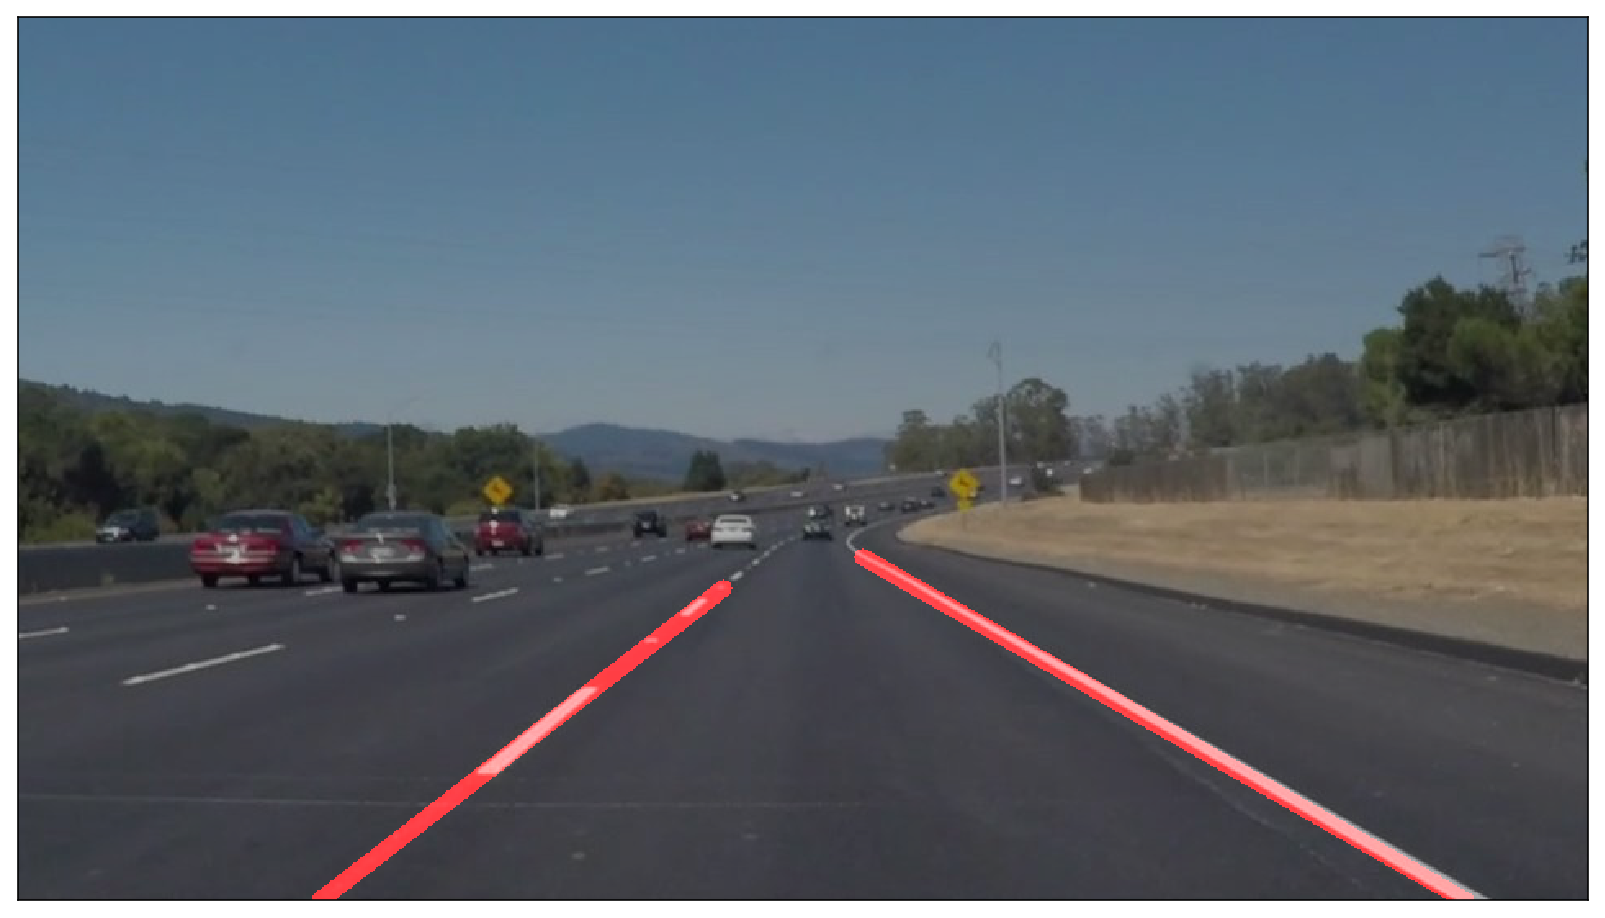

In [90]:
img = plt.imread("test_images/solidWhiteCurve.jpg")
line_image = np.copy(img)*0   
lines = apply_hough(img)

rp1,rp2,lp1,lp2 = find_lines(lines)
draw_lane(line_image,rp1,rp2,lp1,lp2)

img_ret = weighted_img(line_image, img, α=0.7, β=1., γ=0.)

plt.figure(figsize=(11, 11))
plt.imshow(img_ret)
plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

# Finding Lanes Pipeline

Now we are ready to combine all that we have learned to form the lane finding pipeline. 

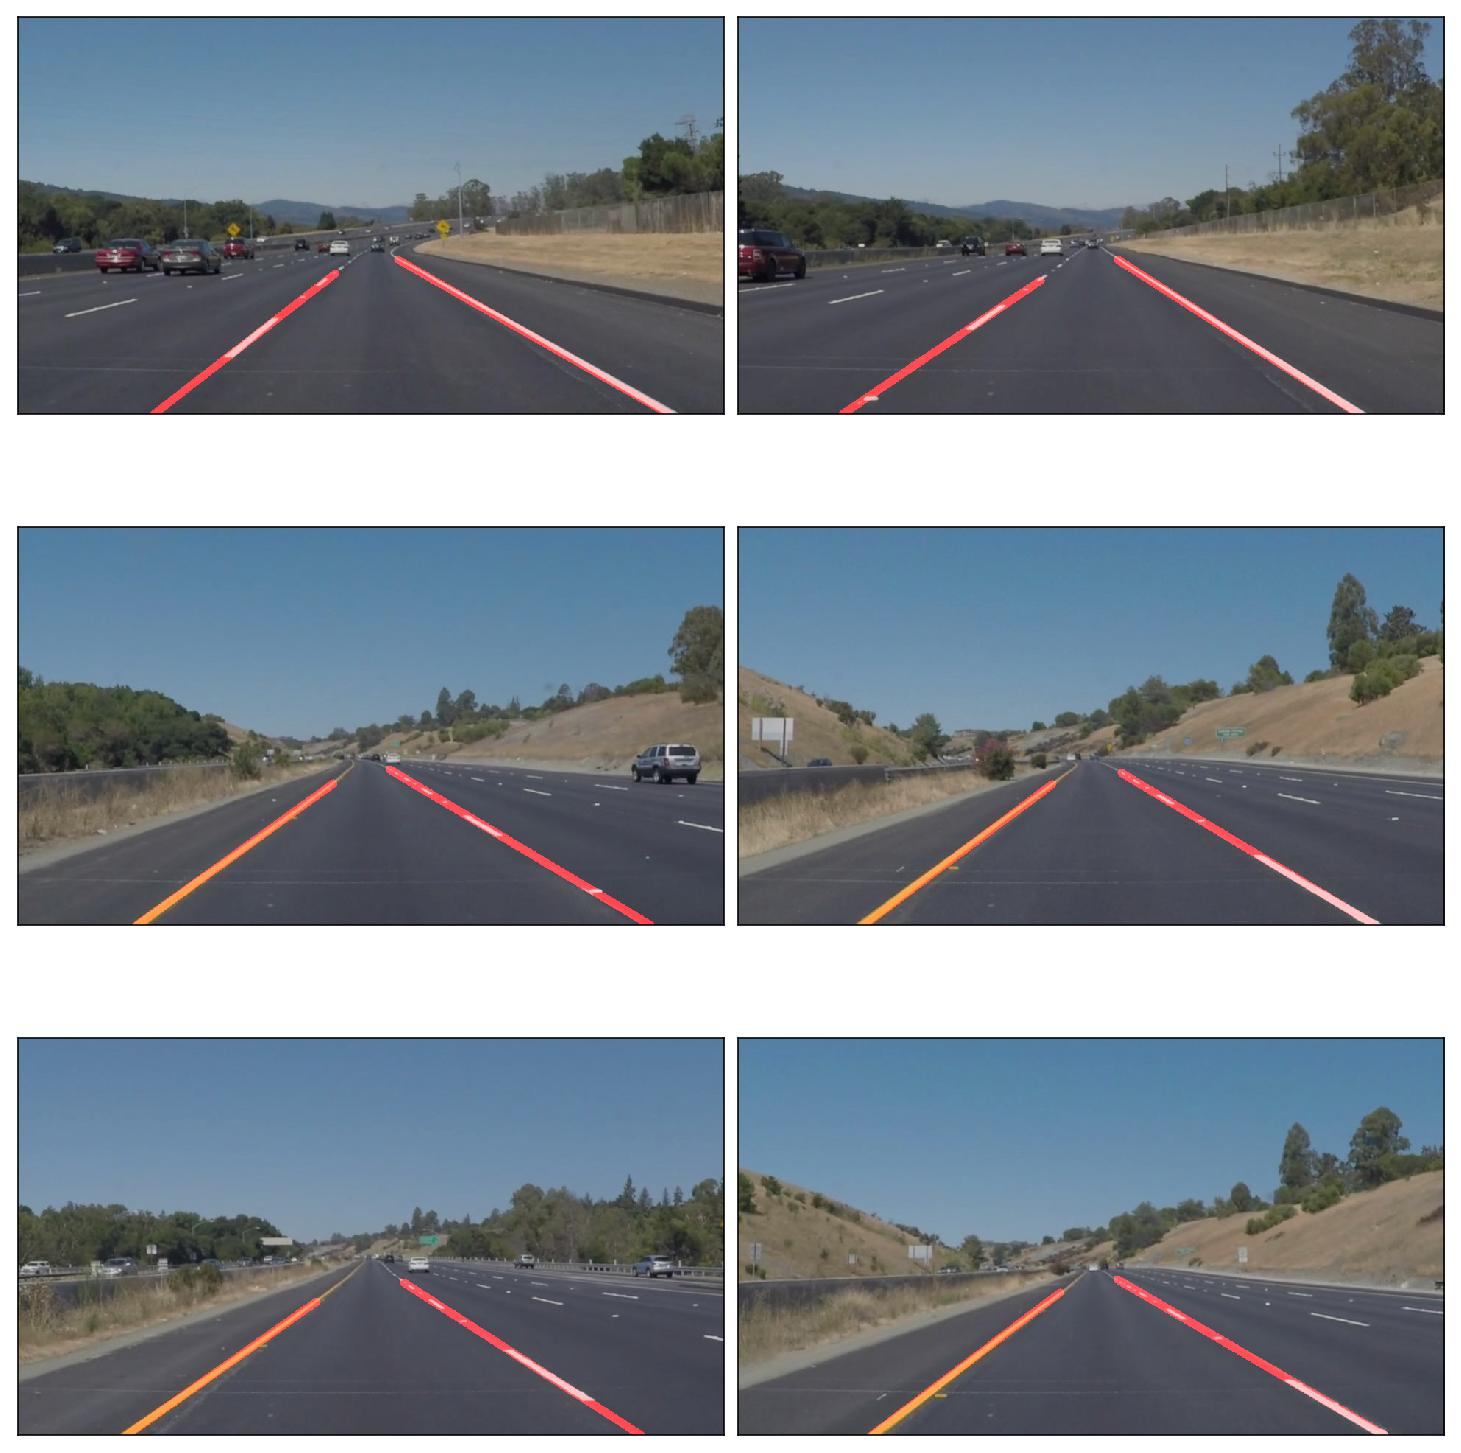

In [91]:
def find_lanes(img):
    line_image = np.copy(img)*0   
    lines = apply_hough(img)

    rp1,rp2,lp1,lp2 = find_lines(lines)
    draw_lane(line_image,rp1,rp2,lp1,lp2)

    img_ret = weighted_img(line_image, img, α=0.8, β=1., γ=0.)
    
    return img_ret

lanes = list(map(find_lanes, test_images))

show_images(lanes)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

Now we are ready to use our image processing pipeline on videos. We process the video frame by frame to find our lines.

I have tested this solution on the provided videos:

`solidYellowLeft.mp4`

In [92]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [93]:
def process_image(image):
    result = find_lanes(image)
    return result

In [98]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [95]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [96]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [97]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] The handle is invalid

# Conclusion

The project was successful in that the video images clearly show the lane lines are detected properly and lines are very smoothly handled.

It only detects the straight lane lines. It is an advanced topic to handle curved lanes (or the curvature of lanes). We'll need to use perspective transformation and also poly fitting lane lines rather than fitting to straight lines.

Having said that, the lanes near the car are mostly straight in the images. The curvature appears at further distance unless it's a steep curve. So, this basic lane finding technique is still very useful.

Another thing is that it won't work for steep (up or down) roads because the region of interest mask is assumed from the center of the image.

For steep roads, we first need to detect the holizontal line (between the sky and the earth) so that we can tell up to where the lines should extend.

